In [8]:
import os
import sys
import os
import numpy as np
from collections import defaultdict
from typing import Tuple

sys.path.append("../")
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from transformers import logging

logging.set_verbosity_error()
from experiments.experiments_utils import (
    load_json,
    load_model,
    load_config,
    deactivate_dropout_layers,
    load_raw_sents,
    load_bert_model,
    load_raw_images,
    load_object,
    compute_embedding_boundaries,
)
from experiments.models.vit import PatchDecoder, ViTForClassification

# Is ViT trained enough for our purpose?

Here are the decoded ViT embeddings for MNIST and CIFAR10:

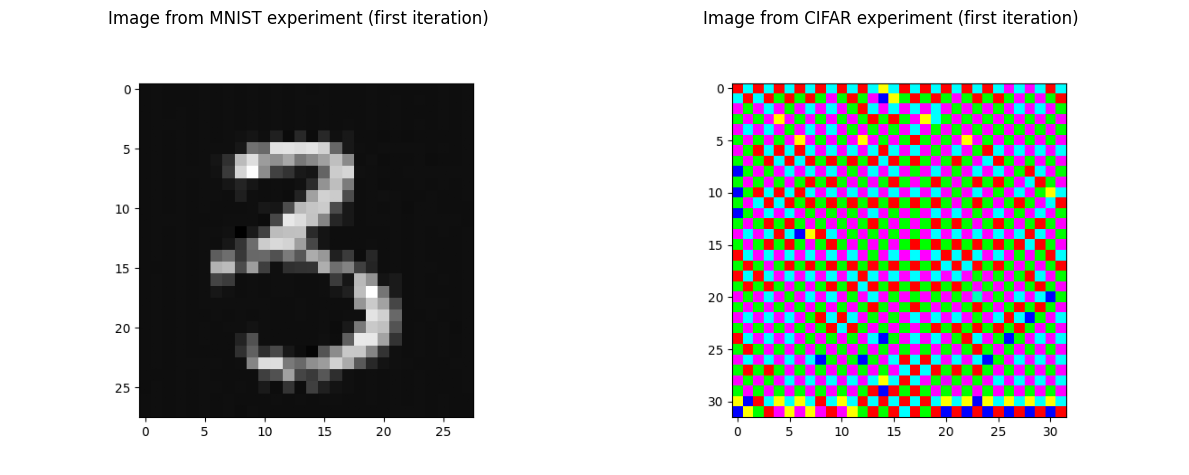

In [9]:
# Paths to the images
image_path1 = "/Users/lizzy/research/input-space-inspection/res/mnist-1-2-all-20241121-143522/simec-img_5000-1/interpretation/patches-0-2-exploration-capping-7.png"
image_path2 = "/Users/lizzy/research/input-space-inspection/res/cifar-1-2-all-20241121-083609/simec-img_1978-1/interpretation/patches-0-8-exploration-capping-2.png"

# Load images
image1 = mpimg.imread(image_path1)
image2 = mpimg.imread(image_path2)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].imshow(image1)
axes[0].axis("off")  # Hide axes
axes[0].set_title("Image from MNIST experiment (first iteration)")

axes[1].imshow(image2)
axes[1].axis("off")  # Hide axes
axes[1].set_title("Image from CIFAR experiment (first iteration)")

plt.tight_layout()
plt.show()

Things to check:

- Is the decoder working properly for the two models? -> Try encoding and decoding an image with no modification to the input embedding. I expect a similar result as above.
- Why is this message appearing when interpreting CIFAR experiments: *Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1087.4214..1036.6598].* -> Inspect the decoded embedding values (min e max) for the two experiments

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MNIST Input Image size: torch.Size([1, 28, 28])
MNIST Input Image min value: 0.0
MNIST Input Image max value: 255.0
Original Image Distribution Quantiles:
  0th quantile: 0.000000	  25th quantile: 0.000000	  50th quantile: 0.000000	  75th quantile: 0.000000	  100th quantile: 255.000000	

Input Embedding Distribution Quantiles:
  0th quantile: -608.405090	  25th quantile: -0.443687	  50th quantile: 0.057374	  75th quantile: 0.590148	  100th quantile: 727.445862	

MNIST Decoded Image size: torch.Size([1, 28, 28])
MNIST Decoded Image min value: -1.4147602087177802e-05
MNIST Decoded Image max value: 255.00003051757812


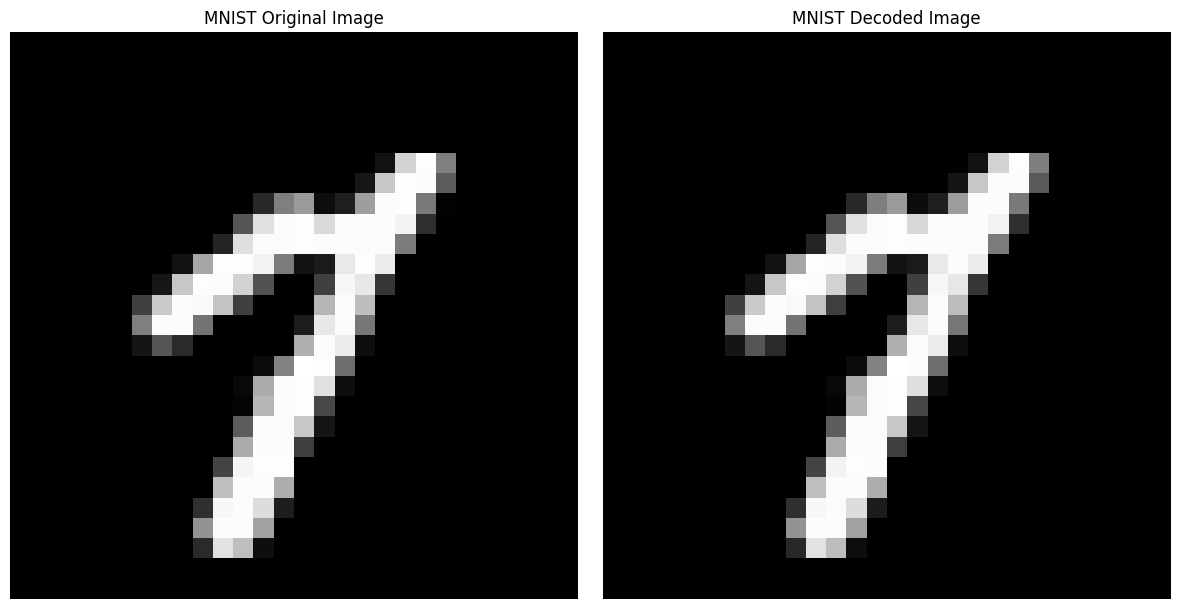

CIFAR Input Image size: torch.Size([3, 32, 32])
CIFAR Input Image min value: 5.0
CIFAR Input Image max value: 209.0
Original Image Distribution Quantiles:
  0th quantile: 5.000000	  25th quantile: 40.750000	  50th quantile: 72.000000	  75th quantile: 111.000000	  100th quantile: 209.000000	

Input Embedding Distribution Quantiles:
  0th quantile: -787.350952	  25th quantile: -77.121498	  50th quantile: -8.336171	  75th quantile: 50.140438	  100th quantile: 954.139709	

CIFAR Decoded Image size: torch.Size([3, 32, 32])
CIFAR Decoded Image min value: 5.0000176429748535
CIFAR Decoded Image max value: 209.00003051757812


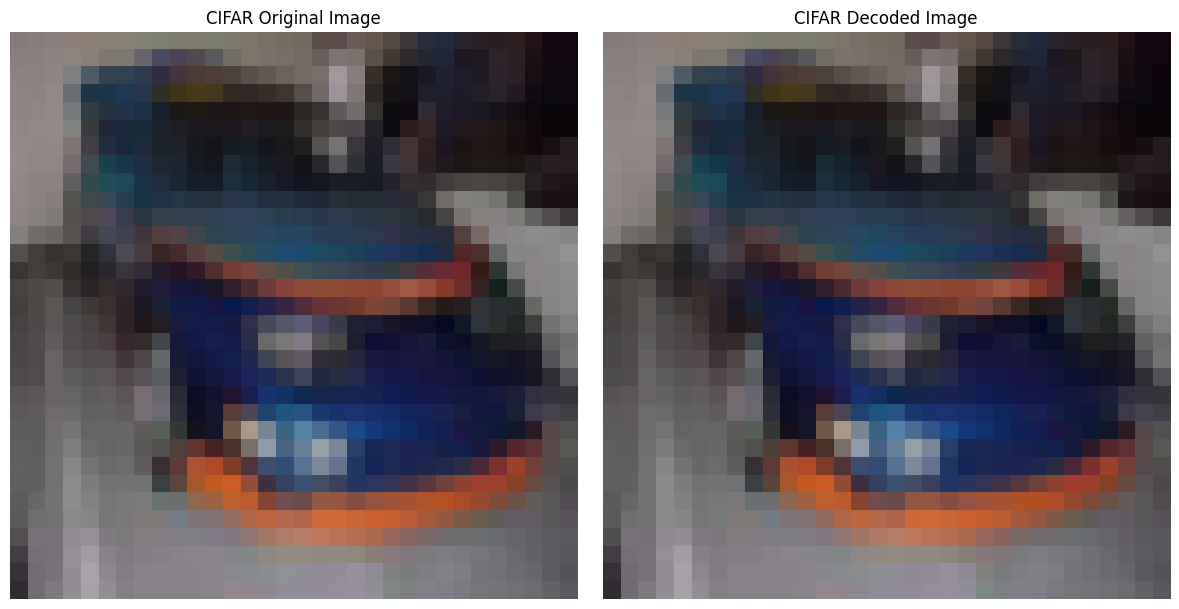

In [11]:
def print_quantiles(distribution, name, quantiles, device):
    """
    Calculate and print the quantiles for a given distribution.

    Args:
        distribution (torch.Tensor): The tensor containing the distribution values.
        name (str): The name of the distribution (e.g., "CIFAR Min").
        quantiles (list): List of quantile values to compute (e.g., [0, 0.25, 0.5, 0.75, 1]).
        device (torch.device): The device to move the tensor to.
    """
    distribution = distribution.detach().to(device)
    quantile_values = torch.quantile(
        distribution, torch.tensor(quantiles, device=device)
    )

    print(f"{name} Distribution Quantiles:")
    for q, val in zip(quantiles, quantile_values):
        print(f"  {int(q * 100)}th quantile: {val.item():.6f}", end="\t")
    print("\n")  # Add a newline for better formatting


def log_image_info(image: torch.Tensor, name: str = "Image") -> None:
    """Log basic info about an image tensor."""
    print(f"{name} size: {image.size()}")
    print(f"{name} min value: {torch.min(image).item()}")
    print(f"{name} max value: {torch.max(image).item()}")


def load_model_and_decoder(
    parameters: dict, device: torch.device
) -> Tuple[torch.nn.Module, torch.nn.Module]:
    """Load a model and its corresponding decoder."""
    model_path = os.path.join("../", parameters["model_path"])
    model_filename = [f for f in os.listdir(model_path) if f.endswith(".pt")]
    if not model_filename:
        raise FileNotFoundError(f"No model file found in {model_path}")

    model, _ = load_model(
        model_path=os.path.join(model_path, model_filename[0]),
        config_path=os.path.join(model_path, "config.json"),
        device=device,
    )
    deactivate_dropout_layers(model)
    model = model.to(device)

    decoder = PatchDecoder(
        image_size=model.image_size,
        patch_size=model.embedding.patch_size,
        model_embedding_layer=model.embedding,
    ).to(device)
    return model, decoder


def visualize_images(
    original: torch.Tensor, decoded: torch.Tensor, dataset: str
) -> None:
    """Display original and decoded images side by side."""
    # Check if the image is grayscale or RGB
    is_grayscale = original.size(0) == 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Original image
    axes[0].imshow(
        original.to(torch.int).permute(1, 2, 0), cmap="gray" if is_grayscale else None
    )
    axes[0].axis("off")
    axes[0].set_title(f"{dataset} Original Image")

    # Decoded image
    axes[1].imshow(
        decoded.to(torch.int).permute(1, 2, 0).detach().cpu().numpy(),
        cmap="gray" if is_grayscale else None,
    )
    axes[1].axis("off")
    axes[1].set_title(f"{dataset} Decoded Image")

    plt.tight_layout()
    plt.show()


def encode_decode(
    decoder: torch.nn.Module,
    model: torch.nn.Module,
    image: torch.Tensor,
    dataset: str,
    quantiles: list = [0, 0.25, 0.5, 0.75, 1],
    q_only: bool = False,
) -> None:
    """Encode and decode an image using the model and decoder."""
    log_image_info(image, f"{dataset} Input Image")

    print_quantiles(image, "Original Image", quantiles, device)

    # Encode original images
    input_patches = model.patcher(image.unsqueeze(0))
    input_embedding = model.embedding(input_patches)

    print_quantiles(input_embedding, "Input Embedding", quantiles, device)

    # Decode embeddings
    decoded_image = decoder(input_embedding.to(device))[0]
    log_image_info(decoded_image, f"{dataset} Decoded Image")

    if not q_only:
        # Visualize the results
        visualize_images(image, decoded_image, dataset)


# Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar_experiment_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/cifar-1-2-all"
mnist_experiment_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/mnist-1-2-all"

# Load parameters
cifar_parameters = load_json(os.path.join(cifar_experiment_path, "parameters.json"))
mnist_parameters = load_json(os.path.join(mnist_experiment_path, "parameters.json"))

# Load models and decoders
cifar_model, cifar_decoder = load_model_and_decoder(cifar_parameters, device)
mnist_model, mnist_decoder = load_model_and_decoder(mnist_parameters, device)

# Load and process images
mnist_image = load_raw_images(mnist_experiment_path)[0][0].to(device)
cifar_image = load_raw_images(cifar_experiment_path)[0][0].to(device)

# Encode and decode images
encode_decode(mnist_decoder, mnist_model, mnist_image, "MNIST")
encode_decode(cifar_decoder, cifar_model, cifar_image, "CIFAR")

We can exclude that the decoder is the problem: it can decode images without changes.

- Is the decoder working properly for the two models? -> Yes
- Why is this message appearing when interpreting CIFAR experiments: *Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1087.4214..1036.6598].* -> Because it wants either floats from 0 to 1 or integers from 0 to 255. However, why are the values so far away from the admissible ones?

Next: evaluate the min and max values distributions for MNIST and CIFAR.

In [12]:
# Paths
cifar_results_path = (
    "/Users/lizzy/research/input-space-inspection/res/cifar-1-2-all-20241121-083609"
)
mnist_results_path = (
    "/Users/lizzy/research/input-space-inspection/res/mnist-1-2-all-20241121-143522"
)

# Quantiles to calculate
quantiles = [0, 0.25, 0.5, 0.75, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR distributions
cifar_min_distribution = load_object(
    os.path.join(cifar_results_path, "min_distribution.pkl")
)
cifar_max_distribution = load_object(
    os.path.join(cifar_results_path, "max_distribution.pkl")
)
print_quantiles(cifar_min_distribution, "CIFAR Min", quantiles, device)
print_quantiles(cifar_max_distribution, "CIFAR Max", quantiles, device)

# MNIST distributions
mnist_min_distribution = load_object(
    os.path.join(mnist_results_path, "min_distribution.pkl")
)
mnist_max_distribution = load_object(
    os.path.join(mnist_results_path, "max_distribution.pkl")
)
print_quantiles(mnist_min_distribution, "MNIST Min", quantiles, device)
print_quantiles(mnist_max_distribution, "MNIST Max", quantiles, device)

CIFAR Min Distribution Quantiles:
  0th quantile: 0.003884	  25th quantile: 24.393753	  50th quantile: 62.212154	  75th quantile: 155.602234	  100th quantile: 1039.821655	

CIFAR Max Distribution Quantiles:
  0th quantile: 0.003884	  25th quantile: 81.830132	  50th quantile: 156.133499	  75th quantile: 337.285095	  100th quantile: 1612.145020	

MNIST Min Distribution Quantiles:
  0th quantile: 0.000108	  25th quantile: 0.225982	  50th quantile: 0.504621	  75th quantile: 0.966200	  100th quantile: 676.687439	

MNIST Max Distribution Quantiles:
  0th quantile: 0.000226	  25th quantile: 0.340459	  50th quantile: 0.861707	  75th quantile: 53.723091	  100th quantile: 729.390137	



Both MNIST and CIFAR images are mapped to embeddings having values greater than 255, with the CIFAR values being much higher. Let's see which is the range of the two images that we have seen before.

In [13]:
encode_decode(mnist_decoder, mnist_model, mnist_image, "MNIST", q_only=True)
print("__________________________________________________")
encode_decode(cifar_decoder, cifar_model, cifar_image, "CIFAR", q_only=True)

MNIST Input Image size: torch.Size([1, 28, 28])
MNIST Input Image min value: 0.0
MNIST Input Image max value: 255.0
Original Image Distribution Quantiles:
  0th quantile: 0.000000	  25th quantile: 0.000000	  50th quantile: 0.000000	  75th quantile: 0.000000	  100th quantile: 255.000000	

Input Embedding Distribution Quantiles:
  0th quantile: -608.405090	  25th quantile: -0.443687	  50th quantile: 0.057374	  75th quantile: 0.590148	  100th quantile: 727.445862	

MNIST Decoded Image size: torch.Size([1, 28, 28])
MNIST Decoded Image min value: -1.4147602087177802e-05
MNIST Decoded Image max value: 255.00003051757812
__________________________________________________
CIFAR Input Image size: torch.Size([3, 32, 32])
CIFAR Input Image min value: 5.0
CIFAR Input Image max value: 209.0
Original Image Distribution Quantiles:
  0th quantile: 5.000000	  25th quantile: 40.750000	  50th quantile: 72.000000	  75th quantile: 111.000000	  100th quantile: 209.000000	

Input Embedding Distribution Quant

Why does the min distribution quantile have such a high min value? Here we see that the example images can have min values below 0.

There was a torch.abs() in the computation of minimum and maximum embeddings. However, why are the values going so far away from the admissible ones? *Got range [-1087.4214..1036.6598]*

Let's try with computing min and max distribution embeddings from all input instances in the dataset. Here I analyse these new distributions.

In [14]:
def show_distributions(
    datasets_names=["cifar", "mnist", "hatespeech", "winobias"],
    quantiles=[0, 0.25, 0.5, 0.75, 1],
):
    distributions = {}
    for dataset_name in datasets_names:
        patch = "all"
        if dataset_name == "winobias":
            patch = "target-word"
        new_max_distribution = load_object(
            f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/max_distribution.pkl"
        )
        new_min_distribution = load_object(
            f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/min_distribution.pkl"
        )
        distributions[dataset_name] = {
            "min": new_min_distribution,
            "max": new_max_distribution,
        }
        print("Min distribution embeddings size: ", new_max_distribution.size())
        print("Max distribution embeddings size: ", new_max_distribution.size())
        print_quantiles(
            new_max_distribution, f"New {dataset_name} MAX", quantiles, device
        )
        print_quantiles(
            new_min_distribution, f"New {dataset_name} MIN", quantiles, device
        )
    return distributions

In [15]:
distrib = show_distributions()

Min distribution embeddings size:  torch.Size([1, 257, 48])
Max distribution embeddings size:  torch.Size([1, 257, 48])
New cifar MAX Distribution Quantiles:
  0th quantile: -50.985588	  25th quantile: 214.945419	  50th quantile: 361.098572	  75th quantile: 557.827332	  100th quantile: 1503.998047	

New cifar MIN Distribution Quantiles:
  0th quantile: -1718.740967	  25th quantile: -576.258850	  50th quantile: -372.096985	  75th quantile: -222.647629	  100th quantile: 94.969498	

Min distribution embeddings size:  torch.Size([1, 197, 48])
Max distribution embeddings size:  torch.Size([1, 197, 48])
New mnist MAX Distribution Quantiles:
  0th quantile: -4.449617	  25th quantile: 0.421742	  50th quantile: 65.851334	  75th quantile: 192.282349	  100th quantile: 757.258240	

New mnist MIN Distribution Quantiles:
  0th quantile: -615.473145	  25th quantile: -137.281219	  50th quantile: -23.913929	  75th quantile: -0.163053	  100th quantile: 3.065415	

Min distribution embeddings size:  torch

These quantiles seem more reasonable with our embeddings.

Let's try running new experiments with these.

Using the maximum padding slows the experiment by a lot, but it is the most accurate way of capping embeddings.
Should we use the minimum of the minimum and the maximum of the maximum?

How really different are the maximum and minimum distributions across token positions?

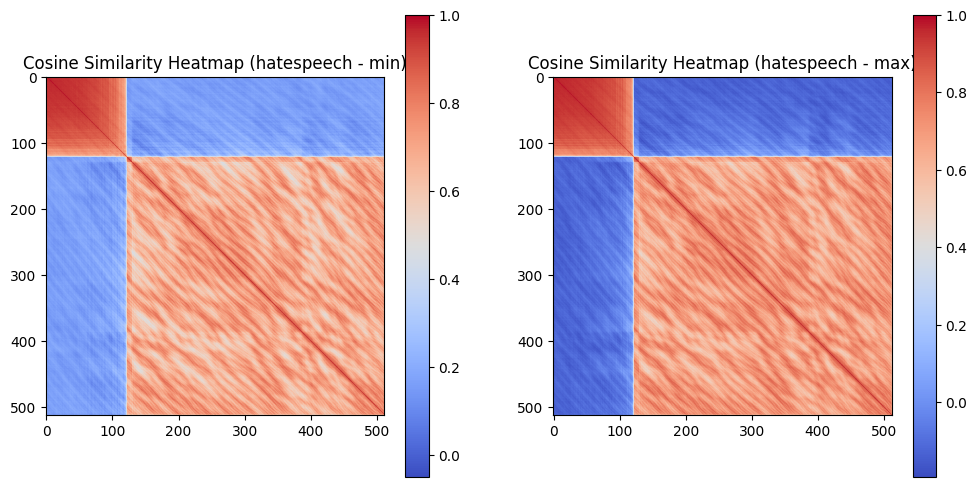

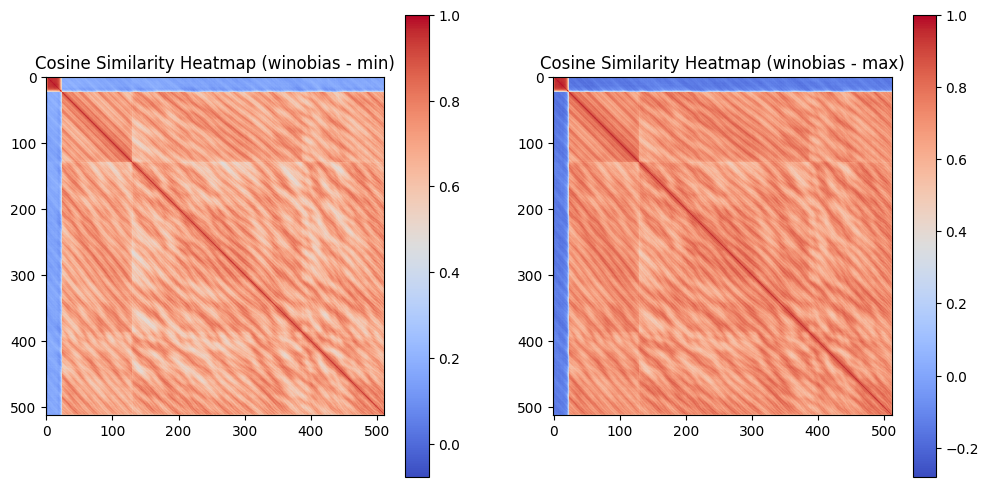

In [16]:
def compute_cosine_similarity(tensor):
    """
    Normalize the input tensor and compute pairwise cosine similarity.

    Args:
        tensor (torch.Tensor): Input tensor of shape [N, D].

    Returns:
        torch.Tensor: Cosine similarity matrix of shape [N, N].
    """
    tensor_norm = torch.nn.functional.normalize(tensor.squeeze(), p=2, dim=1)
    return torch.matmul(tensor_norm, tensor_norm.T)


def plot_similarity_heatmaps(similarity_matrices, titles, figsize=(12, 6)):
    """
    Plot heatmaps for cosine similarity matrices.

    Args:
        similarity_matrices (list[torch.Tensor]): List of cosine similarity matrices.
        titles (list[str]): Titles for the subplots.
        figsize (tuple): Size of the figure.
    """
    num_matrices = len(similarity_matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=figsize)

    for i, (sim_matrix, title) in enumerate(zip(similarity_matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        im = ax.imshow(sim_matrix, cmap="coolwarm")
        ax.set_title(title)
        fig.colorbar(im, ax=ax)

    plt.show()


# Compute cosine similarity matrices
cosine_similarity_hatespeech_min = compute_cosine_similarity(
    distrib["hatespeech"]["min"]
)
cosine_similarity_hatespeech_max = compute_cosine_similarity(
    distrib["hatespeech"]["max"]
)
cosine_similarity_winobias_min = compute_cosine_similarity(distrib["winobias"]["min"])
cosine_similarity_winobias_max = compute_cosine_similarity(distrib["winobias"]["max"])

# Plot heatmaps
plot_similarity_heatmaps(
    [cosine_similarity_hatespeech_min, cosine_similarity_hatespeech_max],
    [
        "Cosine Similarity Heatmap (hatespeech - min)",
        "Cosine Similarity Heatmap (hatespeech - max)",
    ],
)

plot_similarity_heatmaps(
    [cosine_similarity_winobias_min, cosine_similarity_winobias_max],
    [
        "Cosine Similarity Heatmap (winobias - min)",
        "Cosine Similarity Heatmap (winobias - max)",
    ],
)

As you can see, there is a separation between the first 100 positions and the rest. Maybe it is because "the rest" is padding. Let's see which is the sentence in the dataset having most tokens.

In [17]:
def load_and_tokenize_text_data(data_dir, model_path, objective):
    subdirs = [
        os.path.join(data_dir, d)
        for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    ]
    has_subdirs = bool(subdirs)
    if has_subdirs:
        txts = []
        for subdir in subdirs:
            txts += load_raw_sents(subdir)[0]
    else:
        txts, _ = load_raw_sents(data_dir)

    bert_tokenizer, bert_model = load_bert_model(
        model_path, mask_or_cls=objective, device=device
    )
    deactivate_dropout_layers(bert_model)
    tokenized = []
    for txt in txts:
        tokenized.append(
            bert_tokenizer(
                txt,
                return_tensors="pt",
                return_attention_mask=False,
                add_special_tokens=False if txt[0].startswith("[CLS]") else True,
            ).to(device)
        )
    return tokenized

In [18]:
def process_experiment(parameters_path):
    """
    Load experiment parameters, tokenize text data, and print the max input size.

    Args:
        parameters_path (str): Path to the experiment's parameters JSON file.
    """
    experiment = load_json(parameters_path)
    tokenized_data = load_and_tokenize_text_data(
        data_dir=f"../{experiment['orig_data_dir']}",
        model_path=experiment["model_path"],
        objective=experiment["objective"],
    )
    max_input_size = max(el["input_ids"].size(1) for el in tokenized_data)
    print(f"Max input size for {parameters_path}: {max_input_size}")


winobias_experiment_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/winobias-1-2-target-word/parameters.json"
hatespeech_experiment_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/hatespeech-1-2-all/parameters.json"
# Paths to the parameter files
experiment_paths = [
    winobias_experiment_path,
    hatespeech_experiment_path,
]

# Process each experiment
for path in experiment_paths:
    process_experiment(path)

Max input size for /Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/winobias-1-2-target-word/parameters.json: 26
Max input size for /Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/hatespeech-1-2-all/parameters.json: 122


Indeed, the first are similar because they are not only padding. Their similarity decreases as they go further in token number (there are less sentences with many tokens). This could be because of the positional embedding added at each position.

Let's zoom in the first part of these graphs.

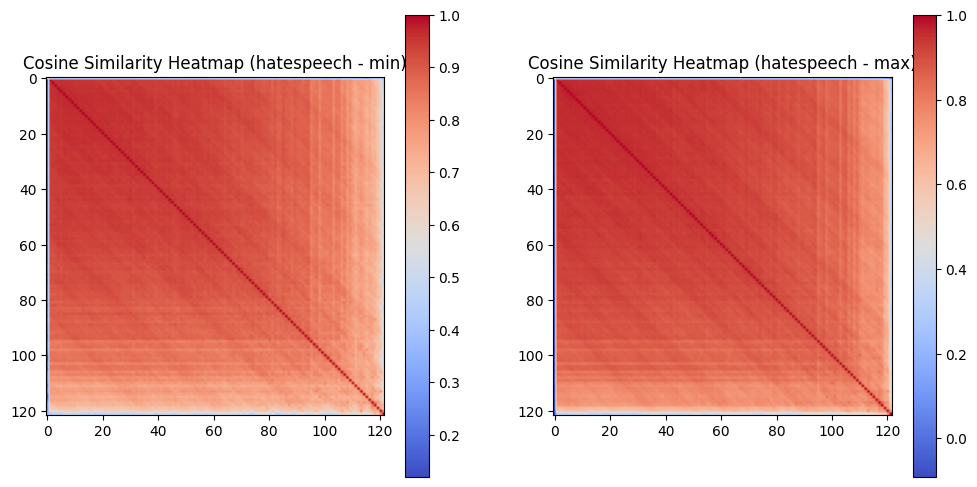

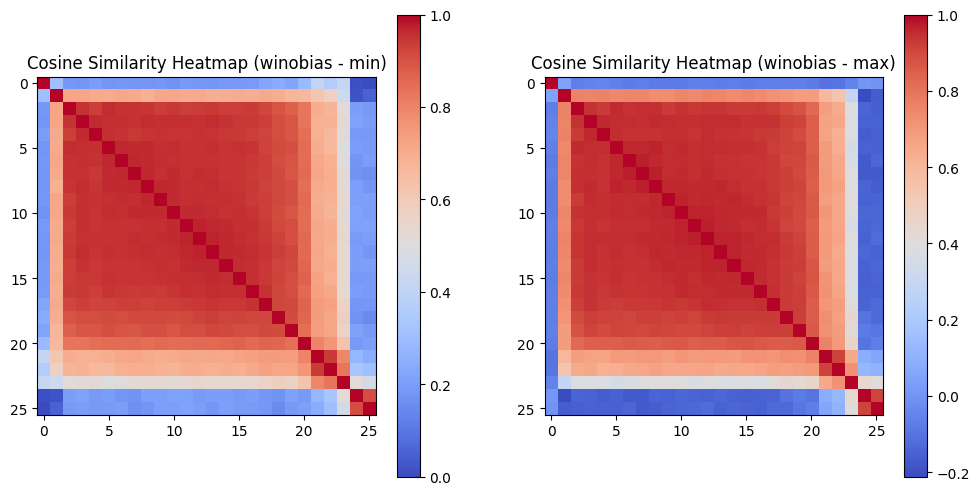

In [19]:
plot_similarity_heatmaps(
    [
        cosine_similarity_hatespeech_min[:122, :122],
        cosine_similarity_hatespeech_max[:122, :122],
    ],
    [
        "Cosine Similarity Heatmap (hatespeech - min)",
        "Cosine Similarity Heatmap (hatespeech - max)",
    ],
)

plot_similarity_heatmaps(
    [
        cosine_similarity_winobias_min[:26, :26],
        cosine_similarity_winobias_max[:26, :26],
    ],
    [
        "Cosine Similarity Heatmap (winobias - min)",
        "Cosine Similarity Heatmap (winobias - max)",
    ],
)

The CLS token seems to have quite different ranges for min and max values. Moreover, positional encodings seem to have (again) a role in differentiating the distributions.

Let's try removing positional encodings.

In [20]:
experiment_winobias = load_json(winobias_experiment_path)
experiment_hatespeech = load_json(hatespeech_experiment_path)
bert_winobias_tokenizer, bert_winobias_model = load_bert_model(
    experiment_winobias["model_path"],
    mask_or_cls=experiment_winobias["objective"],
    device=device,
)
bert_hatespeech_tokenizer, bert_hatespeech_model = load_bert_model(
    experiment_hatespeech["model_path"],
    mask_or_cls=experiment_hatespeech["objective"],
    device=device,
)

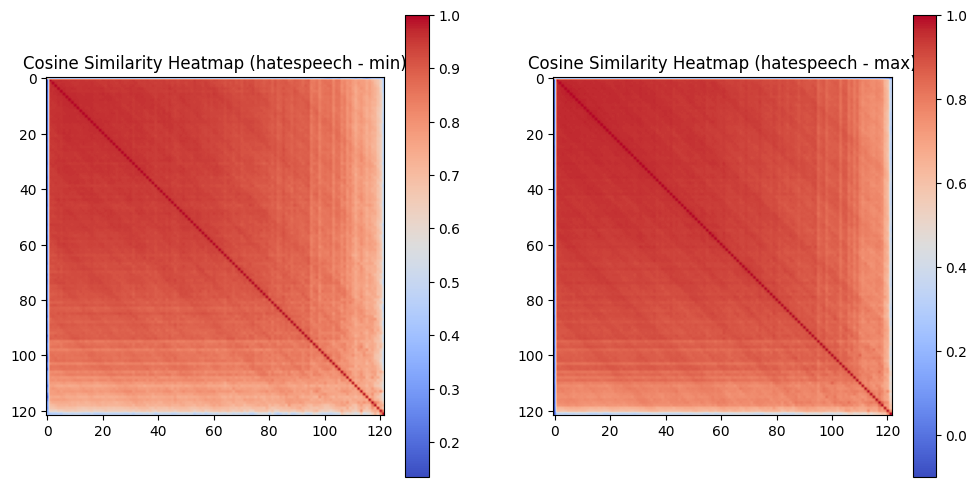

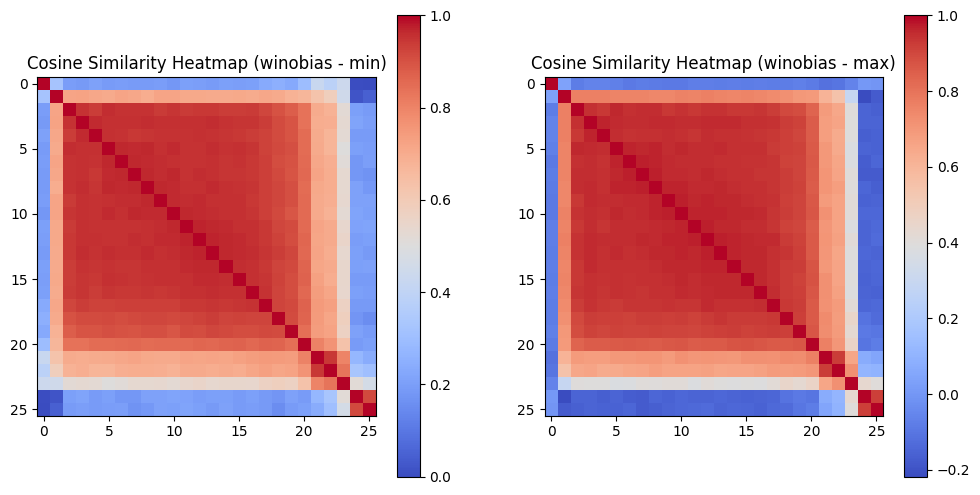

In [21]:
distrib_no_position = {
    k: {
        m: e.squeeze()
        - (
            bert_hatespeech_model if k == "hatespeech" else bert_winobias_model
        ).bert.embeddings.position_embeddings.weight
        for m, e in distrib[k].items()
    }
    for k, v in distrib.items()
    if k in ["hatespeech", "winobias"]
}

# Compute cosine similarity matrices
cosine_similarity_hatespeech_min_no_position = compute_cosine_similarity(
    distrib_no_position["hatespeech"]["min"]
)
cosine_similarity_hatespeech_max_no_position = compute_cosine_similarity(
    distrib_no_position["hatespeech"]["max"]
)
cosine_similarity_winobias_min_no_position = compute_cosine_similarity(
    distrib_no_position["winobias"]["min"]
)
cosine_similarity_winobias_max_no_position = compute_cosine_similarity(
    distrib_no_position["winobias"]["max"]
)

plot_similarity_heatmaps(
    [
        cosine_similarity_hatespeech_min_no_position[:122, :122].detach().numpy(),
        cosine_similarity_hatespeech_max_no_position[:122, :122].detach().numpy(),
    ],
    [
        "Cosine Similarity Heatmap (hatespeech - min)",
        "Cosine Similarity Heatmap (hatespeech - max)",
    ],
)

plot_similarity_heatmaps(
    [
        cosine_similarity_winobias_min_no_position[:26, :26].detach().numpy(),
        cosine_similarity_winobias_max_no_position[:26, :26].detach().numpy(),
    ],
    [
        "Cosine Similarity Heatmap (winobias - min)",
        "Cosine Similarity Heatmap (winobias - max)",
    ],
)

Removing positional embeddings did not seem to be that different. However, let's see how similar embeddings are in the same sentence sto understand wheter we see the same behaviour.

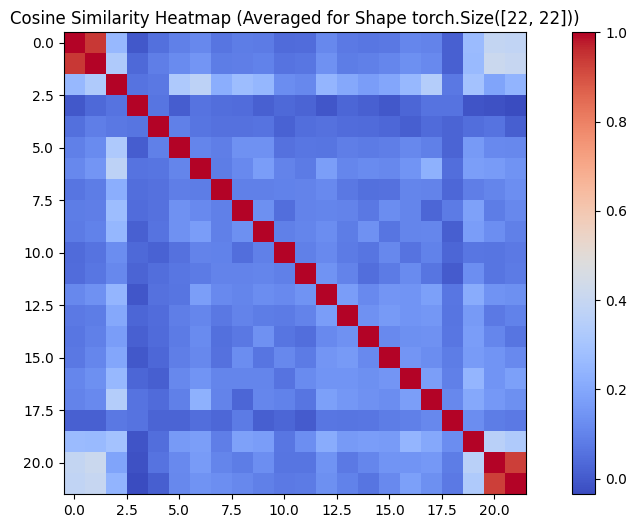

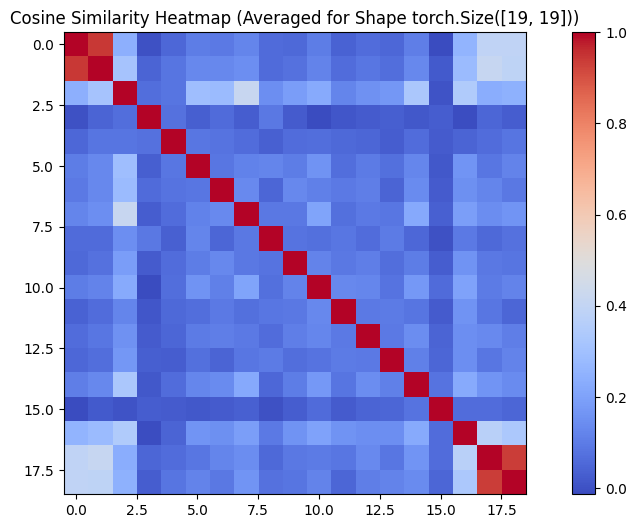

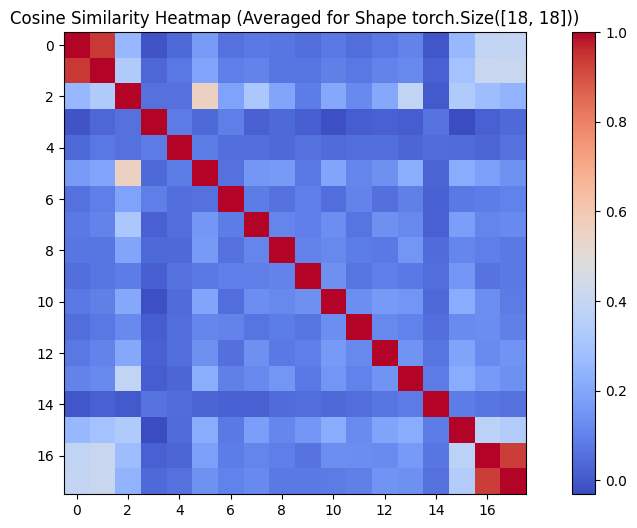

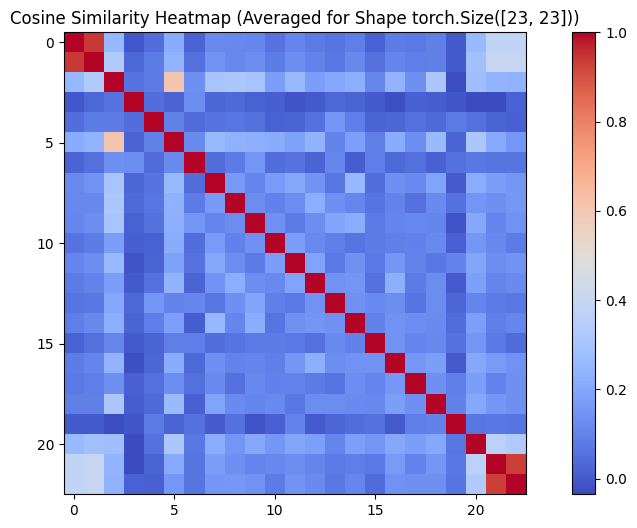

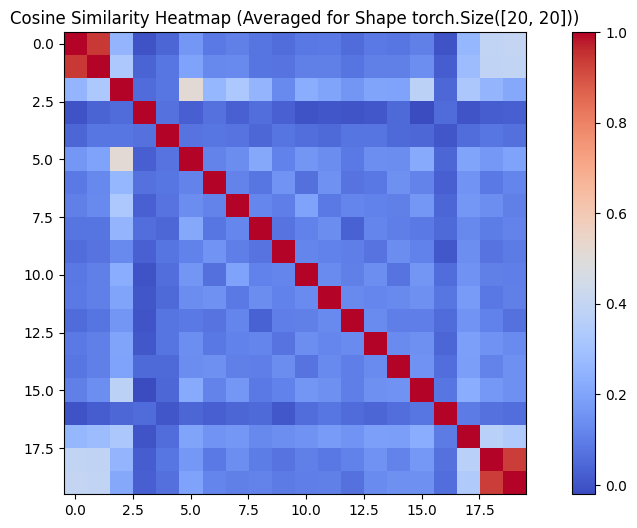

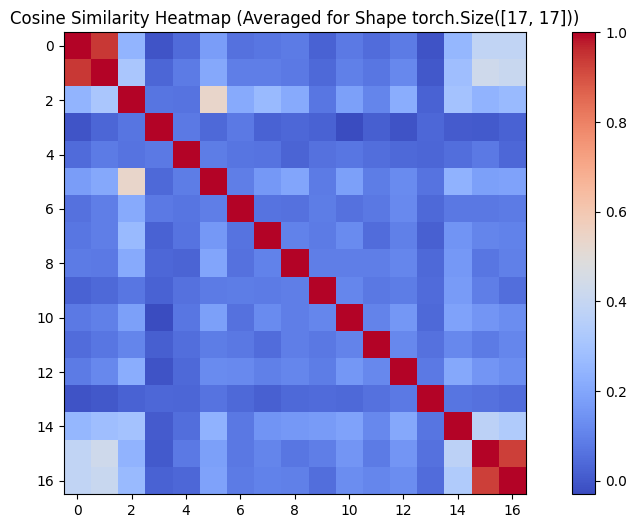

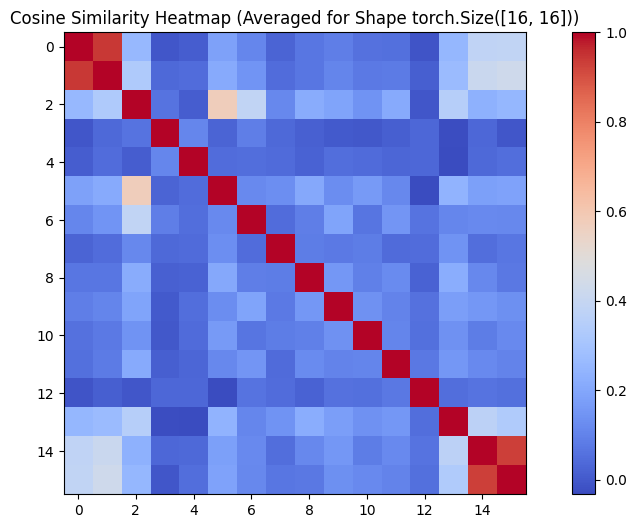

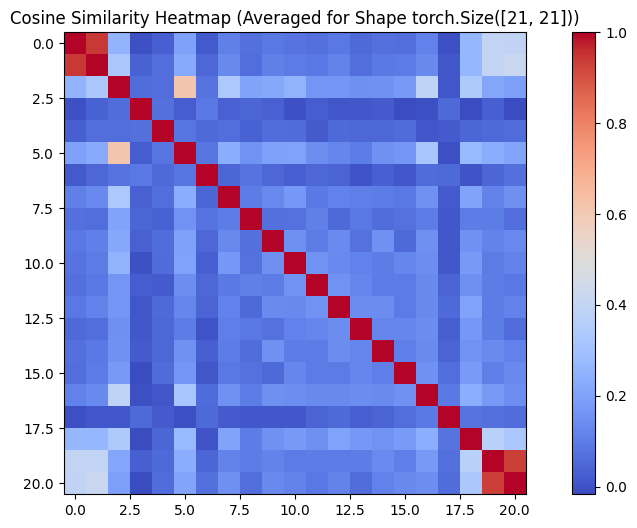

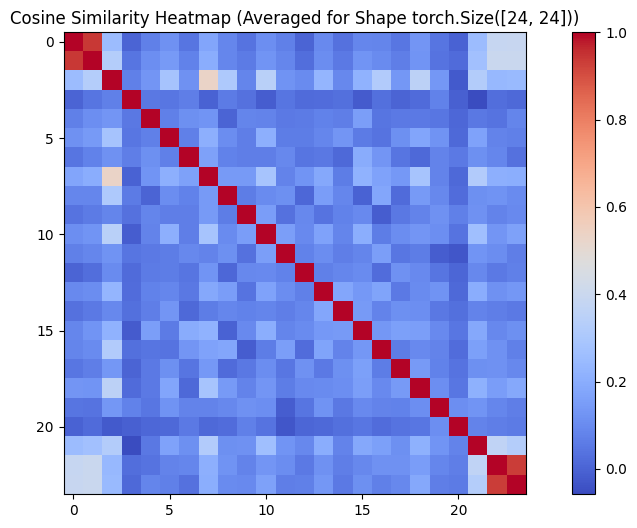

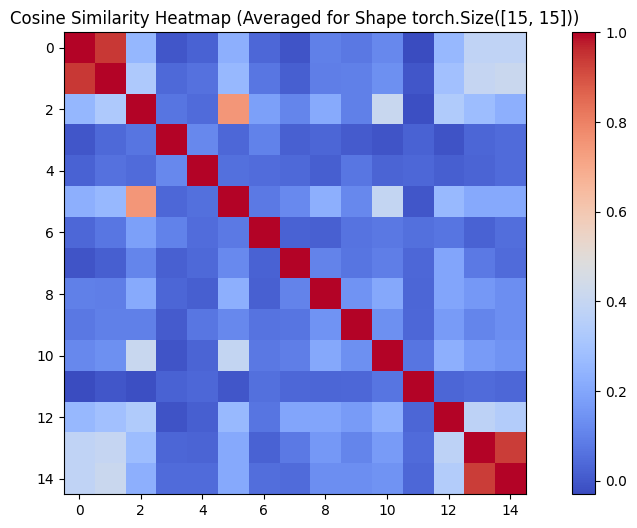

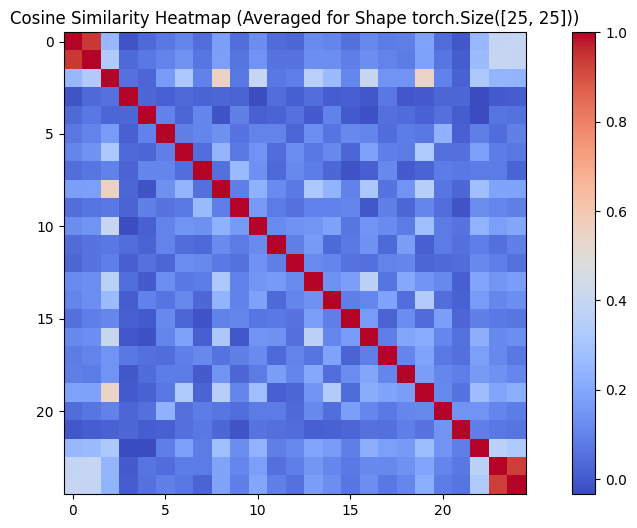

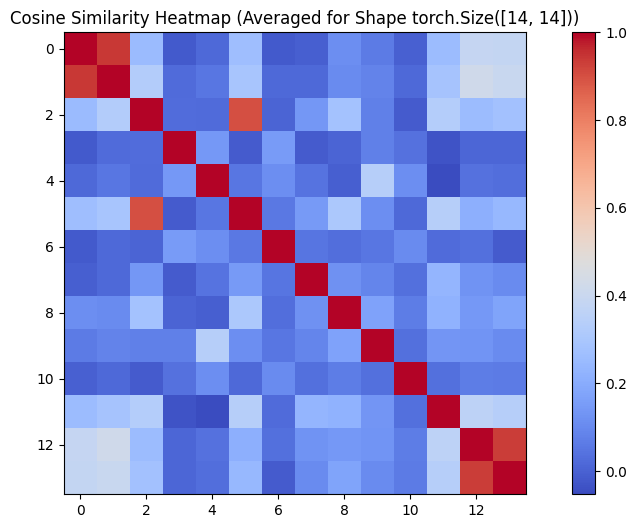

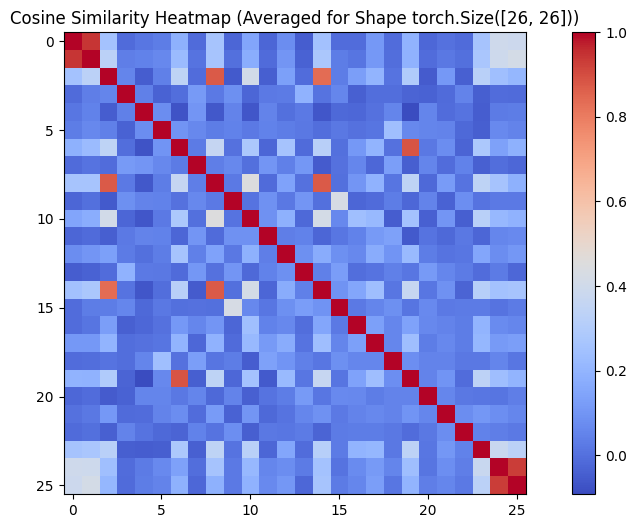

In [22]:
# Load the experiment details
experiment = load_json(winobias_experiment_path)

# Load and tokenize the data
tokenized_data = load_and_tokenize_text_data(
    data_dir=f"../{experiment['orig_data_dir']}",
    model_path=experiment["model_path"],
    objective=experiment["objective"],
)

# A dictionary to group similarity matrices by their shape
similarity_groups = defaultdict(list)

# Iterate over all tokenized inputs
for tokenized_input in tokenized_data:
    # Compute embeddings for the current tokenized input
    output_embeddings = bert_winobias_model.bert.embeddings(**tokenized_input).detach()

    # Compute cosine similarity for the current embeddings
    single_similarity = compute_cosine_similarity(output_embeddings.squeeze())

    # Group similarities by their shape
    similarity_groups[single_similarity.shape].append(
        single_similarity.detach().numpy()
    )

# Compute the averaged similarity matrix for each group
averaged_similarities = {}
for shape, similarities in similarity_groups.items():
    averaged_similarities[shape] = np.mean(similarities, axis=0)

# Plot the averaged similarity heatmaps
for shape, averaged_similarity in averaged_similarities.items():
    plot_similarity_heatmaps(
        [averaged_similarity],
        [f"Cosine Similarity Heatmap (Averaged for Shape {shape})"],
    )

Let's compare this computed distributions to the one extracted from the model.

In [23]:
def compare_distributions(
    datasets_models,
    quantiles=[0, 0.25, 0.5, 0.75, 1],
):
    distributions = {}
    for dataset_name, model in datasets_models.items():
        patch = "all"
        if dataset_name == "winobias":
            patch = "target-word"
        new_max_distribution = (
            load_object(
                f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/max_distribution.pkl"
            )
            .squeeze()
            .max(dim=0)
            .values
        )
        new_min_distribution = (
            load_object(
                f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/min_distribution.pkl"
            )
            .squeeze()
            .min(dim=0)
            .values
        )
        if dataset_name == "cifar":
            davide_min_embeddings, davide_max_embeddings = compute_embedding_boundaries(
                model,
                means=[0.49139968, 0.48215827, 0.44653124],
                sds=[0.24703233, 0.24348505, 0.26158768],
            )
        elif dataset_name == "mnist":
            davide_min_embeddings, davide_max_embeddings = compute_embedding_boundaries(
                model,
                means=[
                    0.1307,
                ],
                sds=[
                    0.3081,
                ],
            )

        else:
            davide_min_embeddings, davide_max_embeddings = compute_embedding_boundaries(
                model,
            )
        distributions[dataset_name] = {
            "min": new_min_distribution,
            "max": new_max_distribution,
            "davide-min": davide_min_embeddings,
            "davide-max": davide_max_embeddings,
        }

        print(dataset_name.upper())
        print("Min distribution embeddings size: ", new_min_distribution.size())
        print("Max distribution embeddings size: ", new_max_distribution.size())
        print("DAVIDE Min distribution embeddings size: ", davide_min_embeddings.size())
        print("DAVIDE Max distribution embeddings size: ", davide_max_embeddings.size())
        for k, v in distributions[dataset_name].items():
            print_quantiles(v, f"{dataset_name} {k}", quantiles, device)

    return distributions


data_model = {
    "cifar": cifar_model,
    "mnist": mnist_model,
    "hatespeech": bert_hatespeech_model.bert,
    "winobias": bert_winobias_model.bert,
}

_ = compare_distributions(data_model)

CIFAR
Min distribution embeddings size:  torch.Size([48])
Max distribution embeddings size:  torch.Size([48])
DAVIDE Min distribution embeddings size:  torch.Size([48])
DAVIDE Max distribution embeddings size:  torch.Size([48])
cifar min Distribution Quantiles:
  0th quantile: -1718.740967	  25th quantile: -853.480652	  50th quantile: -624.390381	  75th quantile: -408.596802	  100th quantile: -45.437084	

cifar max Distribution Quantiles:
  0th quantile: 14.157197	  25th quantile: 372.867096	  50th quantile: 570.908081	  75th quantile: 872.293579	  100th quantile: 1503.998047	

cifar davide-min Distribution Quantiles:
  0th quantile: -38.498165	  25th quantile: -27.678370	  50th quantile: -19.401703	  75th quantile: -13.228420	  100th quantile: -5.089373	

cifar davide-max Distribution Quantiles:
  0th quantile: 5.616539	  25th quantile: 13.400002	  50th quantile: 19.782692	  75th quantile: 27.026142	  100th quantile: 37.764515	

MNIST
Min distribution embeddings size:  torch.Size([48]

/var/folders/1l/m4r3dj_n0lzbdq7sjh0mbr8c0000gp/T/ipykernel_86645/589226114.py:113: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Dataset & Type", y="Value", data=df, inner="quart", scale="width")


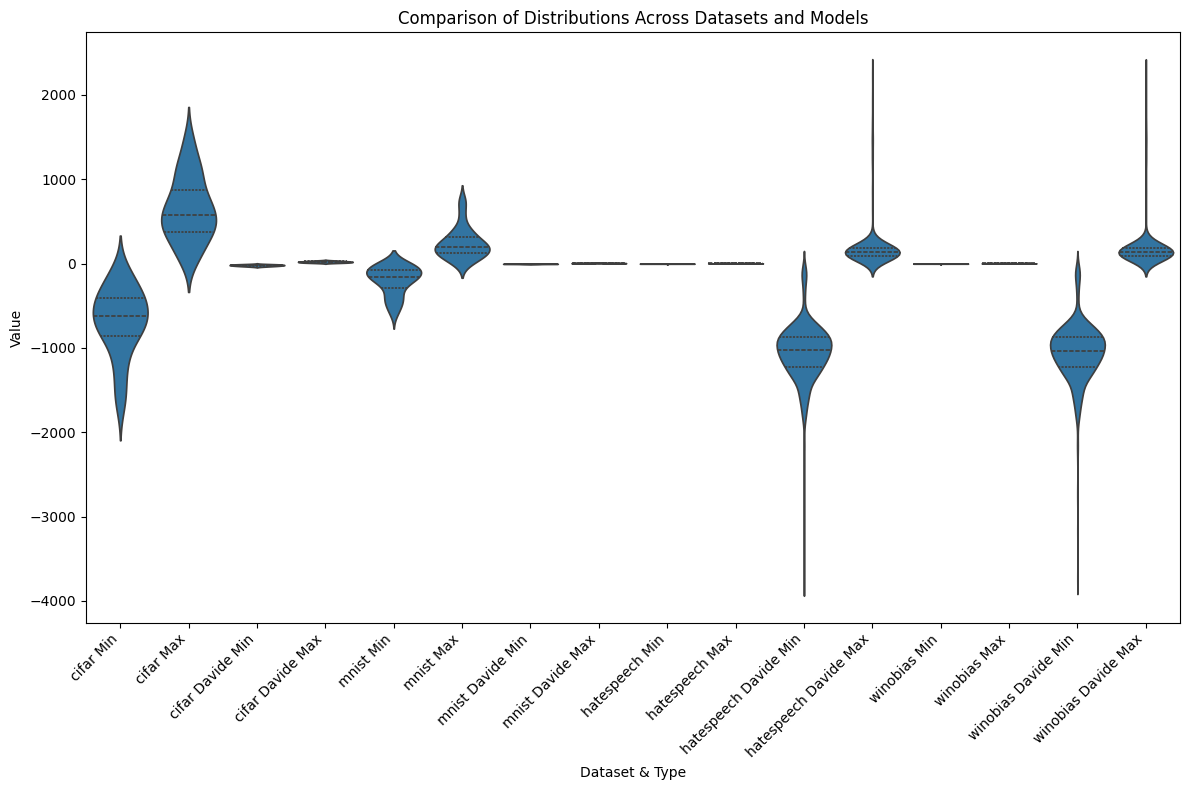

In [24]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def collect_distributions(datasets_models):
    distributions = []
    for dataset_name, model in datasets_models.items():
        patch = "all"
        if dataset_name == "winobias":
            patch = "target-word"
        new_max_distribution = (
            load_object(
                f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/max_distribution.pkl"
            )
            .squeeze()
            .max(dim=0)
            .values
        )
        new_min_distribution = (
            load_object(
                f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/min_distribution.pkl"
            )
            .squeeze()
            .min(dim=0)
            .values
        )
        if dataset_name == "cifar":
            davide_min_embeddings, davide_max_embeddings = compute_embedding_boundaries(
                model,
                means=[0.49139968, 0.48215827, 0.44653124],
                sds=[0.24703233, 0.24348505, 0.26158768],
            )
        elif dataset_name == "mnist":
            davide_min_embeddings, davide_max_embeddings = compute_embedding_boundaries(
                model,
                means=[
                    0.1307,
                ],
                sds=[
                    0.3081,
                ],
            )

        else:
            davide_min_embeddings, davide_max_embeddings = compute_embedding_boundaries(
                model,
            )

        # Flatten and collect the distributions as lists

        distributions.append(
            {
                "Dataset": dataset_name,
                "Type": "Min",
                "Distribution": new_min_distribution.flatten().detach().cpu().numpy(),
            }
        )
        distributions.append(
            {
                "Dataset": dataset_name,
                "Type": "Max",
                "Distribution": new_max_distribution.flatten().detach().cpu().numpy(),
            }
        )

        distributions.append(
            {
                "Dataset": dataset_name,
                "Type": "Davide Min",
                "Distribution": davide_min_embeddings.flatten().detach().cpu().numpy(),
            }
        )
        distributions.append(
            {
                "Dataset": dataset_name,
                "Type": "Davide Max",
                "Distribution": davide_max_embeddings.flatten().detach().cpu().numpy(),
            }
        )

    return distributions


def compare_distributions(datasets_models):
    # Collect distributions
    distributions = collect_distributions(datasets_models)

    # Convert the list of distributions into a DataFrame for plotting
    plot_data = []
    for dist in distributions:
        # Check if the distribution has variance
        if (
            len(set(dist["Distribution"])) > 1
        ):  # Only include distributions with variance
            for value in dist["Distribution"]:
                plot_data.append(
                    {
                        "Dataset & Type": f"{dist['Dataset']} {dist['Type']}",
                        "Value": value,
                    }
                )

    if not plot_data:
        print("No valid data for plotting.")
        return

    df = pd.DataFrame(plot_data)

    # Create a violin plot using seaborn
    plt.figure(figsize=(12, 8))
    sns.violinplot(x="Dataset & Type", y="Value", data=df, inner="quart", scale="width")
    plt.xticks(rotation=45, ha="right")
    plt.title("Comparison of Distributions Across Datasets and Models")
    plt.tight_layout()
    plt.show()

    return distributions


# Example usage
data_model = {
    "cifar": cifar_model,
    "mnist": mnist_model,
    "hatespeech": bert_hatespeech_model.bert,
    "winobias": bert_winobias_model.bert,
}

_ = compare_distributions(data_model)

# CIFAR Tests with new ViT and new capping values

Ho implementato i nuovi valori per tagliare gli embedding presi dai minimi e massimi teorici del modello. In particolare, ho usato il miglior modello ViT addestrato su CIFAR, che ha un'accuratezza di circa il 70%.